Text(0, 0.5, 'Melt rate [m/yr]')

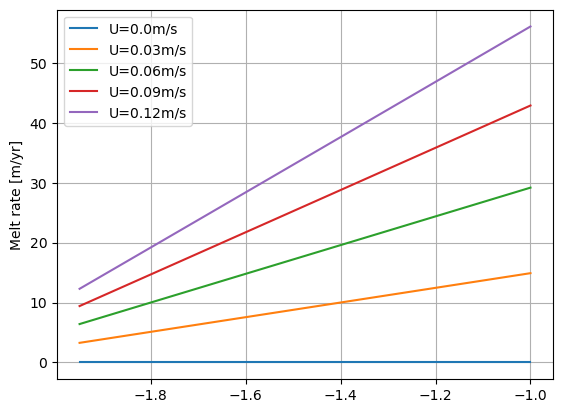

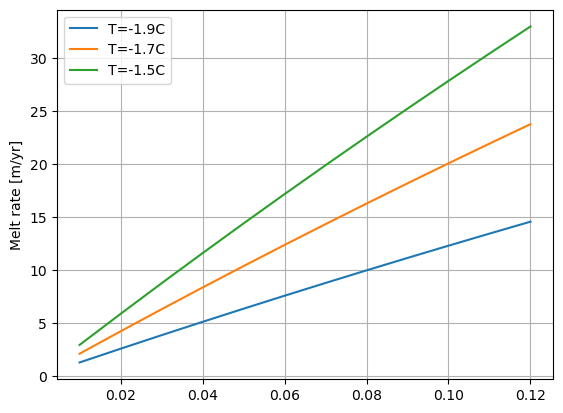

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.optimize import minimize
import h5py
# h5py-3.11.0

# Constants, from Jenkins
rho_i=916
L_i=334000
rho_ic_i_k_i=2.1
rho_w=1030
c_w=3974
c_i=2108 # from internet, not in Jenkins tables

gamma_1=-0.0573
gamma_2=0.0832
gamma_3=-7.53*10**-4

# CdTs=3.1*10**-6 # Diffusion Stanton number
# CdTt=0.011 # Thermal Stanton

CdTt=0.0011 # Thermal Stanton
CdTs=3.1*10**-5 # Diffusion Stanton number

CdTts=5.9*10**-4 # Stanton number - not used?
Cd=0.0097
Tt=0.011
Ts=3.1*10**-4
Tts=0.006

# Fixed values
T_i=-20
S_w=34.9
Pb=400


# Constants, Elin
A=rho_i*L_i
B=rho_i*c_i*T_i #
C=rho_i*c_i  # 
D=rho_w*c_w*CdTt
E=rho_w*CdTs
F=gamma_2+gamma_3*Pb

# a is melt/second! multiply by numbers of seconds per year to get m/yr
N=365*24*3600

fig,ax=plt.subplots()

for U in np.linspace(0,0.12,5):
    TT=np.linspace(-1.95,-1,25)
    aa=[]
    for i,T in enumerate(TT):
        a = sympy.Symbol('a')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        aa.append(N*sympy.nsolve(f1,a,1/N))
    ax.plot(TT,aa,label='U='+str(U)+'m/s')
ax.legend()
ax.grid()   
ax.set_ylabel('Melt rate [m/yr]')


fig,ax=plt.subplots()
for T in [-1.9,-1.7,-1.5]:
    UU=np.linspace(0.01,0.12,12)
    aa=[]
    for i,U in enumerate(UU):
        a = sympy.Symbol('a')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        aa.append(N*sympy.nsolve(f1,a,1/N))
    ax.plot(UU,aa,label='T='+str(T)+'C')
ax.legend()
ax.grid()   
ax.set_ylabel('Melt rate [m/yr]')


In [2]:

U=0.1
T=-1.9
a = sympy.Symbol('a')
f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
a = sympy.nsolve(f1,a,1/N)

S_b=S_w*E/(E+rho_i*a)
T_b=gamma_1*S_b+F

check=-A*a+B*a-C*T_b*a-D*U*(T_b-T)
print(check) # Should be very close to zero
print('S_b='+str(S_b))
print('T_b='+str(T_b))
print('Meltrate='+str(a*N))

2.84217094304040e-14
S_b=34.5128099192920
T_b=-2.19558400837543
Meltrate=12.3325803868886


Try to implement minimization of RMS of observed melt and parameterized  melt based from 3-eqn solver following this recepie: https://datascience.stackexchange.com/questions/69092/how-to-minimize-mean-square-error-using-python

<KeysViewHDF5 ['dh', 'dh_lin', 'melt_lin', 'num', 'spd2', 'spd_lin', 't2', 't_lin', 'vsr', 'vsr_lin']>


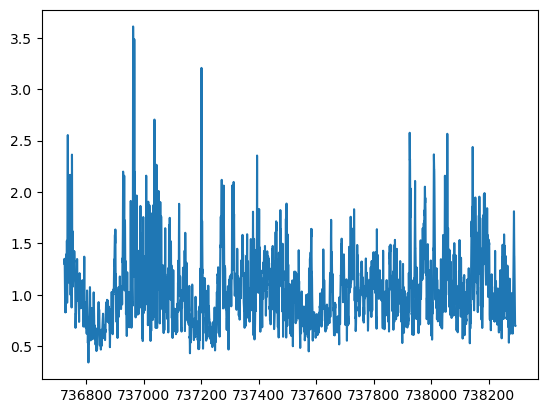

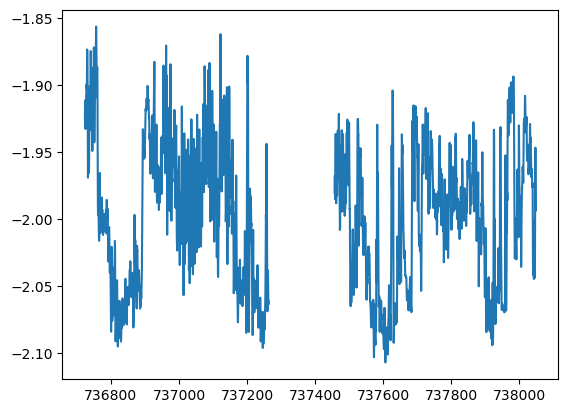

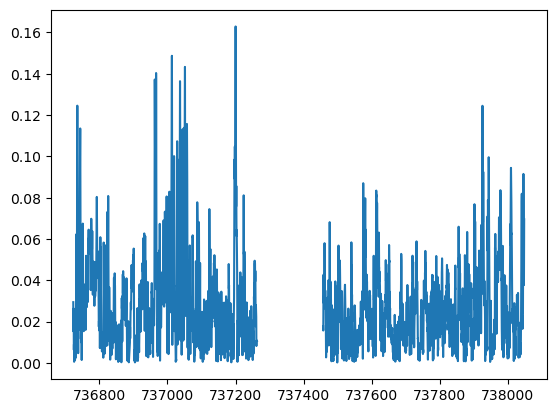

In [3]:
# read obs data
f = h5py.File('M2_series.mat','r')
print(f.keys())

num = np.array(f.get('num'))
dh = np.array(f.get('dh'))
vsr = np.array(f.get('vsr'))
t2 = np.array(f.get('t2'))
spd2 = np.array(f.get('spd2'))

mm = -(dh-np.mean(vsr,axis=0))
t = t2.T
spd = spd2.T

fig,ax=plt.subplots()
ax.plot(num, mm)
fig,ax=plt.subplots()
ax.plot(num, t)
fig,ax=plt.subplots()
ax.plot(num, spd)



In [6]:
# velocity and temperature series
#UU = np.linspace(0,0.12,25)
#TT = np.linspace(-1.95,-1,25)
## melt rate series
#melt_obs = UU*TT

# fidn non-neagtive values
ii = np.isfinite(spd * t * mm)
UU = spd[ii]
TT = t[ii]
mm_obs = mm[ii]

def melt_para():
    aa=[]
    for i,element in enumerate(TT):
        T = TT[i]
        U = UU[i]
        #a = 5 +5
        # a = T_i +5
        a = sympy.Symbol('a')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        aa.append(N*sympy.nsolve(f1,a,1/N))
    return aa


# from sklearn.metrics import r2_score

def r2_score_man(y_obs, y_pred):
    """
    Calculate the coefficient of determination (R^2) between the observed data and the predicted data.

    Parameters:
    y_obs (numpy array): The observed data.
    y_pred (numpy array): The predicted data.

    Returns:
    float: The R^2 value.
    """
    # Calculate the residuals (differences between observed and predicted data)
    resid = y_pred - y_obs
    
    # Calculate the sum of squares of residuals
    SSresid = np.sum(resid ** 2)
    
    # Calculate the total sum of squares (variance of the observed data times the number of observations minus one)
    # Note: np.var with ddof=1 calculates the sample variance
    SStotal = (len(y_obs) - 1) * np.var(y_obs, ddof=1)
    
    # Calculate the R^2 value
    r2_val = 1 - SSresid / SStotal
    
    return r2_val

# Example usage
# ys = np.array([...])  # Observed data
# y1s = np.array([...]) # Predicted data
# r_squared = calculate_r_squared(ys, y1s)
# print(r_squared)

mm_par = melt_para()

#print(str(mm_par))

#melt_r2 = r2_score_man(melt_obs,melt_para)
#print(str(melt_r2))

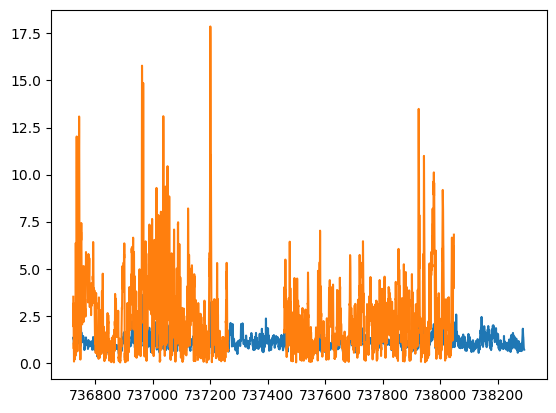

In [8]:

mmp = mm*np.nan
mmp[ii]=mm_par

fig,ax=plt.subplots()
ax.plot(num, mm)
ax.plot(num, mmp)
